# Melting Temperature (Tm)

In [1]:
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc

mpl.rcParams['pdf.fonttype'] = 42

from matplotlib.ticker import ScalarFormatter
%matplotlib inline

## Constants

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/melting_temperature_tm'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

PROCESSED_DATA_SHEETNAME = 'melting_temperature_tm'
RAW_DATA_SHEETNAME = 'melting_temperature_tm_raw'

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################

tm_type = 'Tm D'

df = pd.read_excel(
    FHS.get_data_filename(), sheet_name=PROCESSED_DATA_SHEETNAME
)[0:45][['Protein', tm_type]]

df = FHS.add_manuscript_name_to_df(
    df, synonym_column='Protein',
    new_column='manuscript_name'
)[['manuscript_name', tm_type]]


df['delta_wt'] = df.apply(
    lambda row: row[tm_type] - np.mean(df[df.manuscript_name=='WT TEM-1'][tm_type]),
    axis=1
)
df['sample_mean'] = df.apply(
    lambda row: np.mean(df[df.manuscript_name==row['manuscript_name']][tm_type]),
    axis=1
)
df['sample_delta_wt'] = df.apply(
    lambda row: np.mean(df[df.manuscript_name==row['manuscript_name']][tm_type]) - \
                np.mean(df[df.manuscript_name=='WT TEM-1'][tm_type]),
    axis=1
)

#add 50's even though they aren't there - will indicate in plot
df = pd.concat([
    df, 
    pd.DataFrame({
        'manuscript_name': ['50.a', '50.a', '50.a','50.b', '50.b', '50.b'],
        tm_type: np.full(6, 0),
        'delta_wt': np.full(6, 0),
        'sample_mean': np.full(6, 0),
        'sample_delta_wt': np.full(6, 0)
    })
]).reset_index().drop('index', axis='columns')

#remove non-existant samples from sample order
sample_order = FHS.get_sample_order(df.manuscript_name)

In [5]:
#load raw data
raw_df = pd.read_excel(
    FHS.get_data_filename(), sheet_name=RAW_DATA_SHEETNAME,
)

## Plot Figures

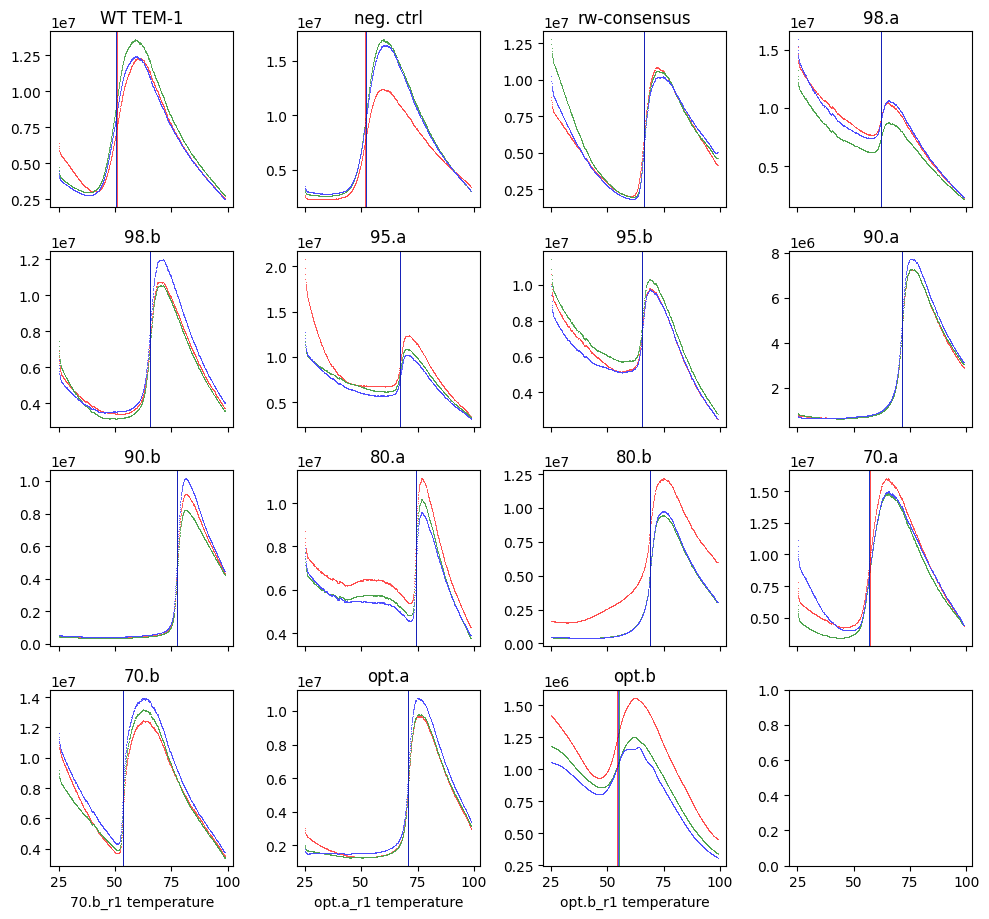

In [6]:
def plot_melting_curves():
    colors = { 1: "red", 2: "green", 3: "blue" }
    samples_to_plot = []

    fig, axes = plt.subplots(
        nrows=4, ncols=4, sharex=True, 
    )
    fig.set_size_inches(10, 10)
    axes = axes.flatten()

    sample_order_wo_50s = [
        s for s in sample_order if s not in ['50.a', '50.b']
    ]
    for idx, samplename in enumerate(sample_order_wo_50s):
        ax = axes[idx]
        
        r1_temp_str = "{0}_r1 temperature".format(samplename)
        r1_fluor_str = "{0}_r1 fluorescence".format(samplename)
        r2_temp_str = "{0}_r2 temperature".format(samplename)
        r2_fluor_str = "{0}_r2 fluorescence".format(samplename)
        r3_temp_str = "{0}_r3 temperature".format(samplename)
        r3_fluor_str = "{0}_r3 fluorescence".format(samplename)
        
        plotting_df = raw_df[[
            r1_temp_str, r1_fluor_str,
            r2_temp_str, r2_fluor_str,
            r3_temp_str, r3_fluor_str,
        ]]
        for repidx in range(0, 3):
            sns.scatterplot(
                plotting_df, 
                x="{0}_r{1} temperature".format(samplename, repidx+1), 
                y="{0}_r{1} fluorescence".format(samplename, repidx+1),
                s=0.5, color=colors[repidx+1],
                ax=ax
            )
            overall_tm = df[df.manuscript_name==samplename].iloc[repidx]
            ax.axvline(
                x=overall_tm["Tm D"], 
                color=colors[repidx+1],
                linewidth=0.5
            )
        ax.set_xticks([25, 50, 75, 100])
        ax.set_title(samplename)
        ax.set_ylabel(None)
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    fig.savefig(OUTPUT_DIR+'/Tm_raw_FINAL.pdf')
plot_melting_curves()

/var/folders/9p/fjc932bj5n11050s1nv1kvdc0000gn/T/ipykernel_61667/2797627900.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)


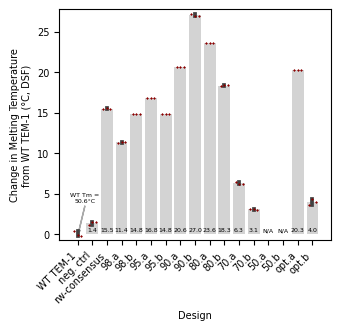

In [7]:
def plot_final():
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(3.5, 3)

    #plot final call
    
    bp = sns.barplot(
        data=df,
        x='manuscript_name', y='delta_wt',
        color='lightgray', linewidth=0.1, order=sample_order,
        ax=ax
    )
    
    #add text values to result
    for idx, samplename in enumerate(sample_order):
        bar_details = bp.patches[idx]
        val = '{0:.1f}'.format(
            np.mean(df[df.manuscript_name==samplename]['delta_wt'])
        )

        y=.5
        x=bar_details.xy[0] + (bar_details.get_width() / 2)

        if samplename in ['50.a', '50.b']: val = 'N/A'
        elif samplename == 'WT TEM-1': 
            val = 'WT Tm =\n{0:.1f}°C'.format(
                np.mean(df[df.manuscript_name==samplename][tm_type])
            )
            y=4.5
            x=0.5
            fontsize=8
            ax.arrow(.5, 3.5, -.4, -3.0, width=.005, 
                     head_width=.2, color='darkgray')

        ax.text(
            x=x, y=y,
            horizontalalignment='center', verticalalignment='center',
            s=val, fontsize=4.5
        )

    #plot raw datapoints, but "smart" jitter so all are visible
    rawdatapoints = {'manuscript_name': [], 'x':[], 'y': []}
    for idx, samplename in enumerate(sample_order):
        if samplename not in ['50.a', '50.b']:
            bar_details = bp.patches[idx]
            padding = 0.2 * bar_details.get_width()
            bar_x_start = bar_details.xy[0] + padding
            bar_width = bar_details.get_width() - (2 * padding)
            
            tmp_df = df[df.manuscript_name==samplename]
            rep_spacing = 1 / 2 * bar_width
            rawdatapoints['manuscript_name'].append(samplename)
            rawdatapoints['manuscript_name'].append(samplename)
            rawdatapoints['manuscript_name'].append(samplename)
            rawdatapoints['x'].append(bar_x_start)
            rawdatapoints['x'].append(bar_x_start + (1 * rep_spacing))
            rawdatapoints['x'].append(bar_x_start + (2 * rep_spacing))
            rawdatapoints['y'].append(tmp_df.iloc[0]['delta_wt'])
            rawdatapoints['y'].append(tmp_df.iloc[1]['delta_wt'])
            rawdatapoints['y'].append(tmp_df.iloc[2]['delta_wt'])
    rawdatapoints = pd.DataFrame(rawdatapoints)
    ax.scatter(
        x=rawdatapoints['x'], y=rawdatapoints['y'], 
        color='darkred', s=2, zorder=10,
        marker='D', linewidth=0
    )
    
    #set text
    #ax.set_title('Designs have Increased Thermostability', fontsize=24)
    ax.set_ylabel('Change in Melting Temperature\nfrom WT TEM-1 (°C, DSF)', fontsize=7)
    ax.set_xlabel('Design', fontsize=7)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        label.set_fontsize(7)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

    ax.set_ylim([-0.75, ax.get_ylim()[1]-0.75])
    fig.savefig(OUTPUT_DIR+'/Tm_FINAL.pdf')

plot_final()

In [8]:
def get_source_data():
    return df.assign(
        idx = df.index,
        sort_order = lambda df: df.manuscript_name.apply(
            lambda n: sample_order.index(n)
        )
    ).sort_values(
        by=['sort_order', 'idx']
    ).assign(
        rep_num = np.array(
            [[1,2,3] for sample_name in sample_order]
        ).flatten()
    )[[
        'manuscript_name', 'rep_num', 'delta_wt', 'sample_mean', 'sample_delta_wt', 'Tm D'
    ]].rename(columns={
        'manuscript_name': 'Sample',
        'rep_num': 'Rep #',
        'delta_wt': 'Replicate ΔTm (°C, replicate Tm - mean of WT TEM-1)',
        'sample_mean': 'Tm (°C, mean of sample replicates)',
        'sample_delta_wt': 'Sample ΔTm (°C, mean of sample replicates - mean of WT TEM-1)',
        'Tm D': 'Tm (°C)'
    })
get_source_data().to_csv(
    OUTPUT_DIR+'/Tm_source_data.tab', sep ='\t', index=False
)